In [1]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=20b7582d-ddf6-4d1b-932e-2b975f45403b
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:23<00:00, 62.1MB/s]


'/content/shared_file.zip'

In [2]:

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


ZIP file opened successfully.
Extraction complete.


In [4]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define constants
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"  # Replace with the root directory of your data

# Create a list to store the paths and labels of all images
train_data = []
test_data = []

# Populate the list with paths and labels
for phase in data_dirs:
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            if phase == 'T4_Ptrain':
                train_data.append((image_path, label))
            else:
                test_data.append((image_path, label))

# Split train_data into training and validation sets while maintaining class distribution
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB mode
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return img, label_tensor

# Image preprocessing with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# Image preprocessing without augmentation for testing and validation
test_val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])


Using device: cuda


In [6]:

# Create custom datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# DataLoaders for batching and shuffling
batch_size = 32  # Define the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use DenseNet121 model
model = timm.create_model("hf_hub:timm/densenet121.ra_in1k", pretrained=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Modify the final layer to match the number of classes in the dataset
num_classes = len(data_dirs['T4_Ptrain'])
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model.to(device)  # Move model to GPU

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)  # Set learning rate to 10^-3

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)  # Reduce factor, patience, and lower bound for LR

# Define loss function
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:

# Train the model
num_epochs = 100  # Set number of epochs to 100

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        # Ensure the input tensor is passed correctly
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Adjust learning rate
    scheduler.step(val_loss)


Epoch 1/100, Train Loss: 0.8316, Train Accuracy: 61.60%, Val Loss: 0.8525, Val Accuracy: 59.55%


Epoch 2/100, Train Loss: 0.7346, Train Accuracy: 66.07%, Val Loss: 0.8264, Val Accuracy: 60.35%


Epoch 3/100, Train Loss: 0.6873, Train Accuracy: 69.18%, Val Loss: 0.9573, Val Accuracy: 58.60%


Epoch 4/100, Train Loss: 0.6137, Train Accuracy: 72.21%, Val Loss: 0.6891, Val Accuracy: 71.02%


Epoch 5/100, Train Loss: 0.5836, Train Accuracy: 74.32%, Val Loss: 0.7631, Val Accuracy: 65.13%


Epoch 6/100, Train Loss: 0.5349, Train Accuracy: 76.75%, Val Loss: 0.6753, Val Accuracy: 69.11%


Epoch 7/100, Train Loss: 0.5165, Train Accuracy: 77.11%, Val Loss: 0.6421, Val Accuracy: 71.66%


Epoch 8/100, Train Loss: 0.5006, Train Accuracy: 79.03%, Val Loss: 0.9768, Val Accuracy: 58.28%


Epoch 9/100, Train Loss: 0.4801, Train Accuracy: 80.82%, Val Loss: 0.6464, Val Accuracy: 67.52%


Epoch 10/100, Train Loss: 0.4612, Train Accuracy: 80.74%, Val Loss: 0.6321, Val Accuracy: 72.61%


Epoch 11/100, Train Loss: 0.4331, Train Accuracy: 82.14%, Val Loss: 0.5889, Val Accuracy: 75.32%


Epoch 12/100, Train Loss: 0.4240, Train Accuracy: 82.46%, Val Loss: 0.7138, Val Accuracy: 71.66%


Epoch 13/100, Train Loss: 0.4128, Train Accuracy: 83.53%, Val Loss: 1.1016, Val Accuracy: 42.99%


Epoch 14/100, Train Loss: 0.3857, Train Accuracy: 84.09%, Val Loss: 0.5699, Val Accuracy: 76.43%


Epoch 15/100, Train Loss: 0.3777, Train Accuracy: 84.13%, Val Loss: 0.9823, Val Accuracy: 53.03%


Epoch 16/100, Train Loss: 0.3522, Train Accuracy: 86.16%, Val Loss: 0.6915, Val Accuracy: 74.04%


Epoch 17/100, Train Loss: 0.3463, Train Accuracy: 86.60%, Val Loss: 0.5626, Val Accuracy: 76.27%


Epoch 18/100, Train Loss: 0.3255, Train Accuracy: 86.92%, Val Loss: 0.7471, Val Accuracy: 71.02%


Epoch 19/100, Train Loss: 0.3274, Train Accuracy: 86.84%, Val Loss: 0.6081, Val Accuracy: 72.61%


Epoch 20/100, Train Loss: 0.3173, Train Accuracy: 86.84%, Val Loss: 0.5154, Val Accuracy: 79.62%


Epoch 21/100, Train Loss: 0.3423, Train Accuracy: 86.52%, Val Loss: 0.5394, Val Accuracy: 79.30%


Epoch 22/100, Train Loss: 0.2802, Train Accuracy: 88.52%, Val Loss: 0.7138, Val Accuracy: 74.52%


Epoch 23/100, Train Loss: 0.2815, Train Accuracy: 88.64%, Val Loss: 0.5502, Val Accuracy: 81.53%


Epoch 24/100, Train Loss: 0.2924, Train Accuracy: 88.40%, Val Loss: 0.5343, Val Accuracy: 77.71%


Epoch 25/100, Train Loss: 0.2392, Train Accuracy: 90.35%, Val Loss: 0.6176, Val Accuracy: 75.80%


Epoch 26/100, Train Loss: 0.2460, Train Accuracy: 90.23%, Val Loss: 0.4443, Val Accuracy: 84.39%


Epoch 27/100, Train Loss: 0.2515, Train Accuracy: 89.99%, Val Loss: 0.7718, Val Accuracy: 70.54%


Epoch 28/100, Train Loss: 0.2362, Train Accuracy: 91.19%, Val Loss: 0.9444, Val Accuracy: 74.04%


Epoch 29/100, Train Loss: 0.2336, Train Accuracy: 90.51%, Val Loss: 0.5242, Val Accuracy: 82.32%


Epoch 30/100, Train Loss: 0.2126, Train Accuracy: 91.71%, Val Loss: 0.7288, Val Accuracy: 74.36%


Epoch 31/100, Train Loss: 0.2309, Train Accuracy: 90.95%, Val Loss: 0.4537, Val Accuracy: 83.92%


Epoch 32/100, Train Loss: 0.2169, Train Accuracy: 91.59%, Val Loss: 0.5052, Val Accuracy: 81.85%


Epoch 33/100, Train Loss: 0.2153, Train Accuracy: 91.79%, Val Loss: 0.9415, Val Accuracy: 70.38%


Epoch 34/100, Train Loss: 0.2234, Train Accuracy: 91.99%, Val Loss: 0.8347, Val Accuracy: 72.93%


Epoch 35/100, Train Loss: 0.1935, Train Accuracy: 93.06%, Val Loss: 0.5424, Val Accuracy: 83.44%


Epoch 36/100, Train Loss: 0.1753, Train Accuracy: 94.26%, Val Loss: 0.4729, Val Accuracy: 82.64%


Epoch 37/100, Train Loss: 0.1953, Train Accuracy: 92.70%, Val Loss: 0.7523, Val Accuracy: 77.07%


Epoch 38/100, Train Loss: 0.1397, Train Accuracy: 94.74%, Val Loss: 0.4329, Val Accuracy: 86.78%


Epoch 39/100, Train Loss: 0.1013, Train Accuracy: 96.41%, Val Loss: 0.3912, Val Accuracy: 88.22%


Epoch 40/100, Train Loss: 0.0998, Train Accuracy: 96.41%, Val Loss: 0.3755, Val Accuracy: 88.54%


Epoch 41/100, Train Loss: 0.0895, Train Accuracy: 96.93%, Val Loss: 0.3954, Val Accuracy: 88.22%


Epoch 42/100, Train Loss: 0.0738, Train Accuracy: 97.53%, Val Loss: 0.3672, Val Accuracy: 89.81%


Epoch 43/100, Train Loss: 0.0777, Train Accuracy: 97.33%, Val Loss: 0.3940, Val Accuracy: 88.69%


Epoch 44/100, Train Loss: 0.0749, Train Accuracy: 97.33%, Val Loss: 0.4024, Val Accuracy: 88.85%


Epoch 45/100, Train Loss: 0.0696, Train Accuracy: 97.69%, Val Loss: 0.3852, Val Accuracy: 89.01%


Epoch 46/100, Train Loss: 0.0700, Train Accuracy: 97.69%, Val Loss: 0.3915, Val Accuracy: 89.33%


Epoch 47/100, Train Loss: 0.0655, Train Accuracy: 97.69%, Val Loss: 0.4127, Val Accuracy: 89.81%


Epoch 48/100, Train Loss: 0.0667, Train Accuracy: 97.69%, Val Loss: 0.4237, Val Accuracy: 89.17%


Epoch 49/100, Train Loss: 0.0574, Train Accuracy: 97.97%, Val Loss: 0.4153, Val Accuracy: 89.65%


Epoch 50/100, Train Loss: 0.0597, Train Accuracy: 97.93%, Val Loss: 0.4643, Val Accuracy: 89.33%


Epoch 51/100, Train Loss: 0.0560, Train Accuracy: 98.37%, Val Loss: 0.4383, Val Accuracy: 88.69%


Epoch 52/100, Train Loss: 0.0602, Train Accuracy: 97.85%, Val Loss: 0.4434, Val Accuracy: 88.06%


Epoch 53/100, Train Loss: 0.0540, Train Accuracy: 98.21%, Val Loss: 0.4622, Val Accuracy: 88.22%


Epoch 54/100, Train Loss: 0.0526, Train Accuracy: 98.41%, Val Loss: 0.4385, Val Accuracy: 89.17%


Epoch 55/100, Train Loss: 0.0461, Train Accuracy: 98.56%, Val Loss: 0.4276, Val Accuracy: 89.81%


Epoch 56/100, Train Loss: 0.0461, Train Accuracy: 98.56%, Val Loss: 0.4532, Val Accuracy: 89.33%


Epoch 57/100, Train Loss: 0.0451, Train Accuracy: 98.72%, Val Loss: 0.4355, Val Accuracy: 89.33%


Epoch 58/100, Train Loss: 0.0519, Train Accuracy: 98.13%, Val Loss: 0.4399, Val Accuracy: 88.38%


Epoch 59/100, Train Loss: 0.0457, Train Accuracy: 98.48%, Val Loss: 0.4412, Val Accuracy: 88.69%


Epoch 60/100, Train Loss: 0.0510, Train Accuracy: 98.21%, Val Loss: 0.4436, Val Accuracy: 87.90%


Epoch 61/100, Train Loss: 0.0471, Train Accuracy: 98.21%, Val Loss: 0.4275, Val Accuracy: 89.33%


Epoch 62/100, Train Loss: 0.0442, Train Accuracy: 98.80%, Val Loss: 0.4186, Val Accuracy: 89.49%


Epoch 63/100, Train Loss: 0.0435, Train Accuracy: 98.60%, Val Loss: 0.4316, Val Accuracy: 89.01%


Epoch 64/100, Train Loss: 0.0464, Train Accuracy: 98.56%, Val Loss: 0.4423, Val Accuracy: 89.01%


Epoch 65/100, Train Loss: 0.0401, Train Accuracy: 98.72%, Val Loss: 0.4634, Val Accuracy: 88.38%


Epoch 66/100, Train Loss: 0.0432, Train Accuracy: 98.44%, Val Loss: 0.4581, Val Accuracy: 88.38%


Epoch 67/100, Train Loss: 0.0429, Train Accuracy: 98.60%, Val Loss: 0.4331, Val Accuracy: 89.17%


Epoch 68/100, Train Loss: 0.0460, Train Accuracy: 98.44%, Val Loss: 0.4268, Val Accuracy: 89.33%


Epoch 69/100, Train Loss: 0.0438, Train Accuracy: 98.64%, Val Loss: 0.4375, Val Accuracy: 88.54%


Epoch 70/100, Train Loss: 0.0387, Train Accuracy: 98.80%, Val Loss: 0.4398, Val Accuracy: 89.33%


Epoch 71/100, Train Loss: 0.0433, Train Accuracy: 98.56%, Val Loss: 0.4311, Val Accuracy: 88.69%


Epoch 72/100, Train Loss: 0.0421, Train Accuracy: 98.68%, Val Loss: 0.4501, Val Accuracy: 89.17%


Epoch 73/100, Train Loss: 0.0397, Train Accuracy: 98.88%, Val Loss: 0.4151, Val Accuracy: 88.69%


Epoch 74/100, Train Loss: 0.0410, Train Accuracy: 98.72%, Val Loss: 0.4323, Val Accuracy: 89.01%


Epoch 75/100, Train Loss: 0.0445, Train Accuracy: 98.52%, Val Loss: 0.4339, Val Accuracy: 89.01%


Epoch 76/100, Train Loss: 0.0490, Train Accuracy: 98.13%, Val Loss: 0.4195, Val Accuracy: 89.49%


Epoch 77/100, Train Loss: 0.0421, Train Accuracy: 98.68%, Val Loss: 0.4298, Val Accuracy: 89.01%


Epoch 78/100, Train Loss: 0.0394, Train Accuracy: 98.80%, Val Loss: 0.4499, Val Accuracy: 88.69%


Epoch 79/100, Train Loss: 0.0433, Train Accuracy: 98.84%, Val Loss: 0.4315, Val Accuracy: 89.17%


Epoch 80/100, Train Loss: 0.0424, Train Accuracy: 98.92%, Val Loss: 0.4062, Val Accuracy: 89.01%


Epoch 81/100, Train Loss: 0.0467, Train Accuracy: 98.37%, Val Loss: 0.4534, Val Accuracy: 88.85%


Epoch 82/100, Train Loss: 0.0353, Train Accuracy: 98.88%, Val Loss: 0.4388, Val Accuracy: 89.01%


Epoch 83/100, Train Loss: 0.0403, Train Accuracy: 98.76%, Val Loss: 0.4138, Val Accuracy: 89.65%


Epoch 84/100, Train Loss: 0.0500, Train Accuracy: 98.52%, Val Loss: 0.4646, Val Accuracy: 89.01%


Epoch 85/100, Train Loss: 0.0384, Train Accuracy: 98.88%, Val Loss: 0.4547, Val Accuracy: 88.85%


Epoch 86/100, Train Loss: 0.0423, Train Accuracy: 98.41%, Val Loss: 0.4590, Val Accuracy: 88.38%


Epoch 87/100, Train Loss: 0.0413, Train Accuracy: 98.76%, Val Loss: 0.4286, Val Accuracy: 88.85%


Epoch 88/100, Train Loss: 0.0369, Train Accuracy: 98.84%, Val Loss: 0.4692, Val Accuracy: 88.54%


Epoch 89/100, Train Loss: 0.0445, Train Accuracy: 98.44%, Val Loss: 0.4519, Val Accuracy: 88.22%


Epoch 90/100, Train Loss: 0.0476, Train Accuracy: 98.68%, Val Loss: 0.4655, Val Accuracy: 88.69%


Epoch 91/100, Train Loss: 0.0380, Train Accuracy: 98.72%, Val Loss: 0.4433, Val Accuracy: 89.65%


Epoch 92/100, Train Loss: 0.0423, Train Accuracy: 98.72%, Val Loss: 0.4477, Val Accuracy: 88.54%


Epoch 93/100, Train Loss: 0.0421, Train Accuracy: 98.88%, Val Loss: 0.4304, Val Accuracy: 88.85%


Epoch 94/100, Train Loss: 0.0429, Train Accuracy: 98.68%, Val Loss: 0.4258, Val Accuracy: 89.01%


Epoch 95/100, Train Loss: 0.0523, Train Accuracy: 98.13%, Val Loss: 0.4503, Val Accuracy: 88.38%


Epoch 96/100, Train Loss: 0.0393, Train Accuracy: 99.12%, Val Loss: 0.4541, Val Accuracy: 88.85%


Epoch 97/100, Train Loss: 0.0443, Train Accuracy: 98.56%, Val Loss: 0.4533, Val Accuracy: 89.01%


Epoch 98/100, Train Loss: 0.0421, Train Accuracy: 98.68%, Val Loss: 0.4519, Val Accuracy: 88.69%


Epoch 99/100, Train Loss: 0.0447, Train Accuracy: 98.44%, Val Loss: 0.4274, Val Accuracy: 89.01%


Epoch 100/100, Train Loss: 0.0386, Train Accuracy: 98.92%, Val Loss: 0.4315, Val Accuracy: 88.85%


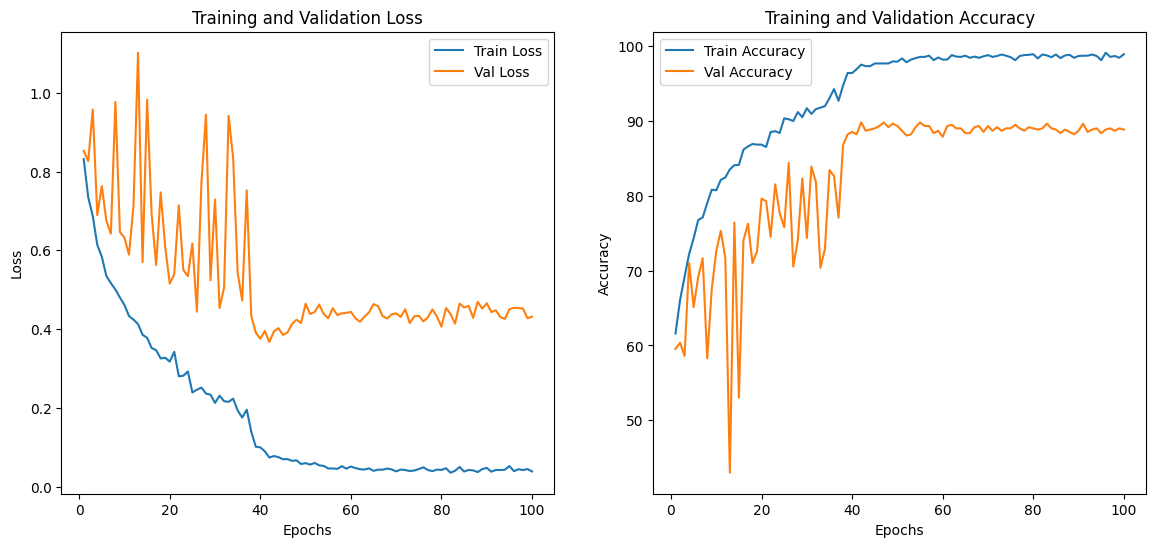

Test Accuracy: 87.56%
              precision    recall  f1-score   support

     Class 0       0.74      0.88      0.81       118
     Class 1       0.92      0.94      0.93       187
     Class 2       0.91      0.84      0.87       322

    accuracy                           0.88       627
   macro avg       0.86      0.89      0.87       627
weighted avg       0.88      0.88      0.88       627



In [8]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


In [9]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)]))

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.88      0.81       118
     Class 1       0.92      0.94      0.93       187
     Class 2       0.91      0.84      0.87       322

    accuracy                           0.88       627
   macro avg       0.86      0.89      0.87       627
weighted avg       0.88      0.88      0.88       627

Confusion Matrix:
[[104   0  14]
 [  0 175  12]
 [ 36  16 270]]

Class-wise Metrics:
Class 0:
  TP: 104
  TN: 473
  FP: 36
  FN: 14
  Recall: 0.881
  Specificity: 0.929
  Precision: 0.743
  F1-score: 0.806
Class 1:
  TP: 175
  TN: 424
  FP: 16
  FN: 12
  Recall: 0.936
  Specificity: 0.964
  Precision: 0.916
  F1-score: 0.926
Class 2:
  TP: 270
  TN: 279
  FP: 26
  FN: 52
  Recall: 0.839
  Specificity: 0.915
  Precision: 0.912
  F1-score: 0.874

Macro-averaged Metrics:
Macro Recall: 0.885
Macro Precision: 0.857
Macro F1-score: 0.869
Accuracy (ACC): 0.876
Balanced Accuracy (BAC): 0.885
Custo